### Current Hyperparameter settings:
* gamma = 2550
* lambda = 1

In [1]:
gamma = 2550
lambdaz = 1

In [2]:
import numpy as np
import random
import scipy.io
import scipy.ndimage
import os
import gc
import random
from PIL import Image
import cv2
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as Fn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
X_A_dir = '/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/'
Y_A_dir = '/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/ground_truth/'

X_A_tdir = '/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/images/'
Y_A_tdir = '/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/ground_truth/'

X_B_dir = '/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/'
Y_B_dir = '/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/ground_truth/'

X_B_tdir = '/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data/images/'
Y_B_tdir = '/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data/ground_truth/'

images_A = [X_A_dir + i for i in os.listdir(X_A_dir)]
images_At = [X_A_tdir + i for i in os.listdir(X_A_tdir)]
images_B = [X_B_dir + i for i in os.listdir(X_B_dir)]
images_Bt = [X_B_tdir + i for i in os.listdir(X_B_tdir)]

gt_A = [Y_A_dir + i for i in os.listdir(Y_A_dir)]
gt_At = [Y_A_tdir + i for i in os.listdir(Y_A_tdir)]
gt_B = [Y_B_dir + i for i in os.listdir(Y_B_dir)]
gt_Bt = [Y_B_tdir + i for i in os.listdir(Y_B_tdir)]

images_train = images_A + images_B
images_test = images_At + images_Bt

gt_train = gt_A + gt_B
gt_test = gt_At + gt_Bt

images_train.sort()
images_test.sort()
gt_train.sort()
gt_test.sort()

In [4]:
def rgb2gray(rgb):                                                      #convert RGB images to grayscale
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

X_train = []
X_test_A = []
X_test_B = []

def generate_data():
    
    for image in images_train:
        X_train.append(rgb2gray(cv2.resize(cv2.imread(image), (256, 256))))
        
    for i in xrange(182):
        X_test_A.append(rgb2gray(cv2.resize(cv2.imread(images_test[i]), (256, 256))))
        
    for i in xrange(182, 498):
        X_test_B.append(rgb2gray(cv2.resize(cv2.imread(images_test[i]), (256, 256))))
        
    return X_train, X_test_A, X_test_B

X_train, X_test_A, X_test_B = generate_data()

print 'Shape of a sample training image: {}'.format(X_train[0].shape)

Shape of a sample training image: (256, 256)


In [5]:
Y_test_A = np.asarray(np.load('/ShanghaiDensities256/densities_test_A.npy'))
Y_test_B = np.asarray(np.load('/ShanghaiDensities256/densities_test_B.npy'))
Y_train = np.asarray(np.load('/ShanghaiDensities256/densities_train.npy'))

print 'Sizes\nTraining: {} (A: {}, B: {})\nTest A: {}\nTest B: {}'.format(len(X_train), len(images_A), len(images_B), len(X_test_A), len(X_test_B))

Sizes
Training: 700 (A: 300, B: 400)
Test A: 182
Test B: 316


In [6]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, norm_layer=nn.BatchNorm2d, input_nc=None, submodule=None, outermost=False, innermost=False):
        super(UnetSkipConnectionBlock, self).__init__()
        
        self.outermost = outermost
        if input_nc == None:
            input_nc = outer_nc
            
        use_bias = norm_layer == nn.InstanceNorm2d
        
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)
        
        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.ReLU()]
            model = down + [submodule] + up
            
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
            
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            
            model = down + [submodule] + up + [nn.Dropout(0.5)]
            
        self.model = nn.Sequential(*model)
        
    def forward(self, input):
        if self.outermost:
            return self.model(input)
        
        else:
            return torch.cat([input, self.model(input)], 1)

In [7]:
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, num_downs=4):
        super(UnetGenerator, self).__init__()
                
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, norm_layer=norm_layer, innermost=True)
        
        for i in xrange(num_downs - 1):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
            
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)
        
        self.model = unet_block
        
    def forward(self, input):
        return self.model(input)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        
        layers = [nn.Conv2d(1, 64, kernel_size=4, stride=2)]
        inner_c=64

        for _ in xrange(4):
            layers += [nn.Conv2d(inner_c, inner_c * 2, kernel_size=4, stride=2), nn.LeakyReLU(0.2, True), nn.BatchNorm2d(inner_c * 2)]
            inner_c = inner_c * 2
            
        layers += [nn.Conv2d(inner_c, 1, kernel_size=6, stride=1), nn.LeakyReLU(0.2, True)]
        self.model = nn.Sequential(*layers)
    
    def forward(self, input):
        output = self.model(input).view(1, -1)
        return Fn.sigmoid(output)

In [10]:
for i in xrange(300):
    Y_train[i] = Y_train[i] * gamma

In [11]:
X_train_tensor = torch.from_numpy(np.asarray(X_train)).unsqueeze(3)
Y_train_tensor = torch.from_numpy(np.asarray(Y_train)).unsqueeze(3)

X_train_tensor = X_train_tensor[:300].permute(0, 3, 1, 2)          #Only for part A first
Y_train_tensor = Y_train_tensor[:300].permute(0, 3, 1, 2)

train_data = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=1, pin_memory = False)

print X_train_tensor.size(), Y_train_tensor.size()

torch.Size([300, 1, 256, 256]) torch.Size([300, 1, 256, 256])


In [12]:
dtype = torch.FloatTensor

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
print dtype
    
G = UnetGenerator(1, 1, norm_layer=nn.BatchNorm2d, num_downs=4).type(dtype)         #apply weights_init for both
D = Discriminator(1).type(dtype)

G.apply(weights_init)
D.apply(weights_init)

G.load_state_dict(torch.load('/model/G.pt'))
D.load_state_dict(torch.load('/model/D.pt'))

G_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))  
D_optim = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

G_optim.load_state_dict(torch.load('/model/G_optim.pt'))
D_optim.load_state_dict(torch.load('/model/D_optim.pt'))

<class 'torch.cuda.FloatTensor'>


In [13]:
def test_on_test(mode = 'A', number = 105, evalz=False):
    
    if evalz == True:
        G.eval()
    
    if mode == 'A':
        img = X_test_A[number]
        mode = Y_test_A
    elif mode == 'B':
        img = X_test_B[number]
        mode = Y_test_B
    else:
        print 'Invalid mode. Use only A or B'
    
    print 'Creating tensor from image...'
    img_v = Variable(torch.from_numpy(img).unsqueeze(0).unsqueeze(1)).type(dtype)
    print 'Tensor of shape: {} created'.format(img_v.size())
    
    #Pass through G
    density_map = G(img_v).view(256, 256).data.cpu().numpy()
    density_map = density_map / gamma
    
    plt.imshow(img)
    plt.title('Image [{}]'.format(np.sum(mode[number])))
    plt.figure()
    plt.title('Density map generated [{}]'.format(np.sum(density_map)))
    plt.imshow(density_map)
    plt.figure()
    plt.title('Ground truth [{}]'.format(np.sum(mode[number])))
    plt.imshow(mode[number])

In [14]:
loss_L1 = nn.L1Loss().type(dtype)

def train(models, optimizers, loss_fn, epochs, evalz = False):
    
    gen, disc = models
    gen_optim, disc_optim = optimizers
    
    for epoch in xrange(epochs):
        gen.train()
        disc.train()
        
        print 'Epoch {} started'.format(epoch + 1)
        
        for i, (X, Y) in enumerate(train_loader):
            X = Variable(X).type(dtype)       #first train discriminator
            Y = Variable(Y).type(dtype)
            
            Y_fake = gen(X)
            true_ = Variable(torch.ones(len(X), 1)).type(dtype)
            fake_ = Variable(torch.zeros(len(X), 1)).type(dtype)
            
            for _ in xrange(2):
                scores_fake = disc(Y_fake)
                scores_real = disc(Y)

                loss1 = loss_fn(scores_fake, fake_)
                loss2 = loss_fn(scores_real, true_)
                loss_d = (loss1 + loss2) * 0.5 

                disc_optim.zero_grad()
                loss_d.backward(retain_graph=True)
                disc_optim.step()
            
            if i % 100 == 0:
                    print 'Discriminator loss after {} batches: {}'.format(i, loss_d.data[0])
            
            #train generator
            
            loss_g = loss_fn(scores_fake, true_) + lambdaz * loss_L1(Y_fake, Y)
            
            if i % 100 == 0:
                print 'Generator loss after {} batches: {}'.format(i, loss_g.data[0])
            
            gen_optim.zero_grad()
            loss_g.backward()
            gen_optim.step()
            
        print 'Epoch ended'
        
        if epoch % 2 == 0:
            n = random.randint(0, 181)
            test_on_test(mode='A', number=n, evalz=evalz)
            
        torch.save(G.state_dict(), 'G.pt')
        torch.save(D.state_dict(), 'D.pt')
        torch.save(G_optim.state_dict(), 'G_optim.pt')
        torch.save(D_optim.state_dict(), 'D_optim.pt')

Epoch 1 started
Discriminator loss after 0 batches: 0.0020811597351
Generator loss after 0 batches: 32.6776046753
Discriminator loss after 100 batches: 7.74861007358e-07
Generator loss after 100 batches: 25.1750907898
Discriminator loss after 200 batches: 8.01688929641e-06
Generator loss after 200 batches: 23.3211669922
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 1.70770217665e-05
Generator loss after 0 batches: 37.0356025696
Discriminator loss after 100 batches: 1.93420819414e-05
Generator loss after 100 batches: 21.650138855
Discriminator loss after 200 batches: 0.000178726666491
Generator loss after 200 batches: 19.6523952484
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 3.98770862375e-05
Generator loss after 0 batches: 44.1775512695
Discriminator loss after 100 batches: 2.40212484641e-05
Generator loss after 100 batches: 29.1351604462
Discriminator loss after 20

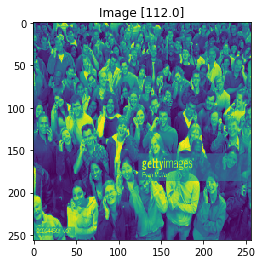

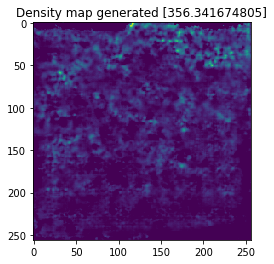

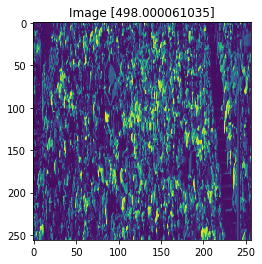

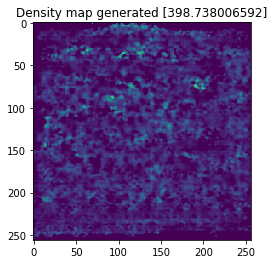

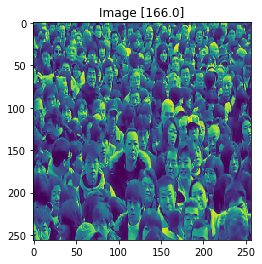

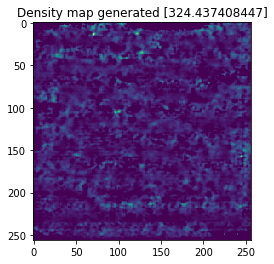

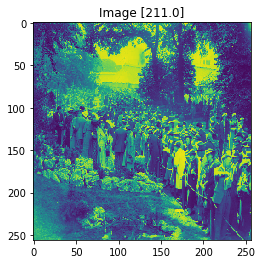

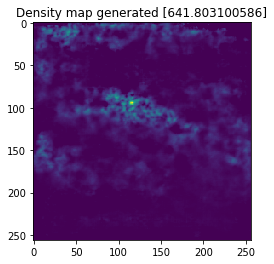

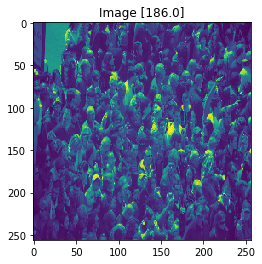

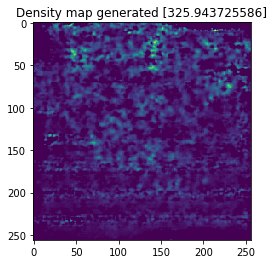

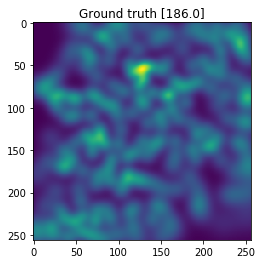

In [15]:
loss_fn = nn.BCELoss().type(dtype)
models = [G, D]
optimizers = [G_optim, D_optim]

train(models, optimizers, loss_fn, 10)

Epoch 1 started
Discriminator loss after 0 batches: 0.000531508820131
Generator loss after 0 batches: 33.2582473755
Discriminator loss after 100 batches: 2.30079222092e-05
Generator loss after 100 batches: 20.8287086487
Discriminator loss after 200 batches: 8.94069742685e-08
Generator loss after 200 batches: 27.9982872009
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 0.000162508673384
Generator loss after 0 batches: 34.855381012
Discriminator loss after 100 batches: 3.12925203616e-06
Generator loss after 100 batches: 25.1925964355
Discriminator loss after 200 batches: 5.96046518808e-08
Generator loss after 200 batches: 26.7010955811
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 1.43649258462e-05
Generator loss after 0 batches: 38.183795929
Discriminator loss after 100 batches: 2.98023309142e-07
Generator loss after 100 batches: 24.9621448517
Discriminator loss after 2

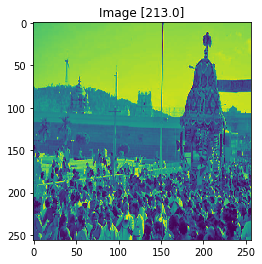

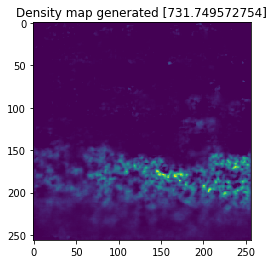

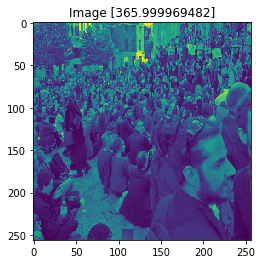

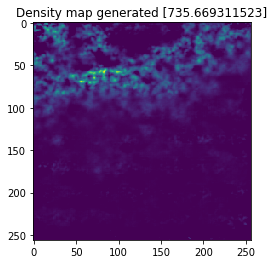

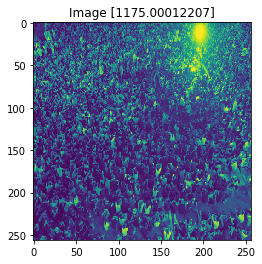

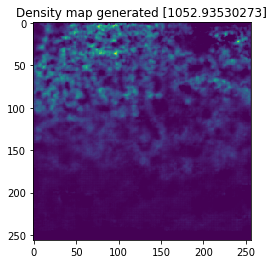

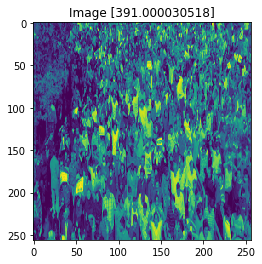

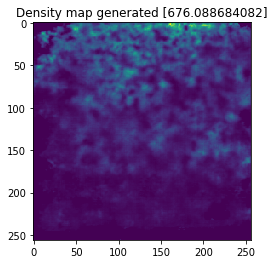

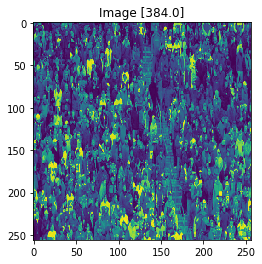

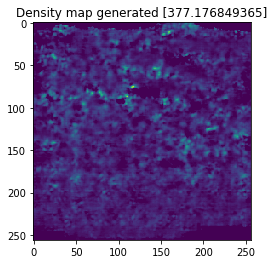

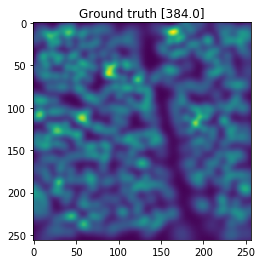

In [16]:
train(models, optimizers, loss_fn, 10)

Epoch 1 started
Discriminator loss after 0 batches: 0.000235970408539
Generator loss after 0 batches: 34.4495887756
Discriminator loss after 100 batches: 7.56984718464e-06
Generator loss after 100 batches: 23.4052467346
Discriminator loss after 200 batches: 0.000112576046376
Generator loss after 200 batches: 18.9001998901
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 0.000361811864423
Generator loss after 0 batches: 33.8679389954
Discriminator loss after 100 batches: 1.28150145429e-06
Generator loss after 100 batches: 24.0235061646
Discriminator loss after 200 batches: 0.000142564837006
Generator loss after 200 batches: 19.4160881042
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 0.00752897653729
Generator loss after 0 batches: 31.2802734375
Discriminator loss after 100 batches: 0.000112486617581
Generator loss after 100 batches: 20.3741912842
Discriminator loss after 

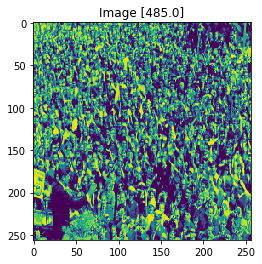

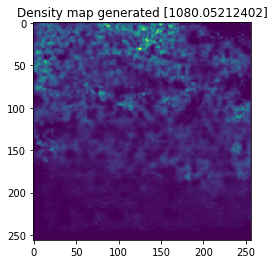

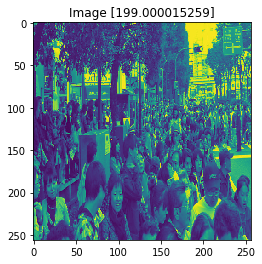

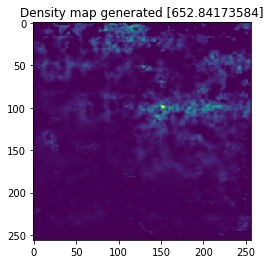

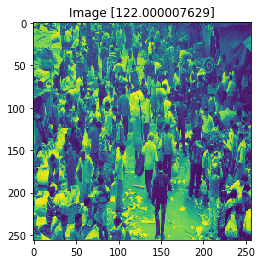

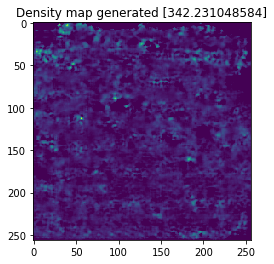

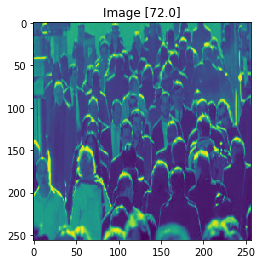

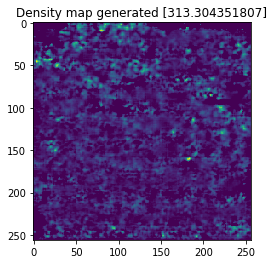

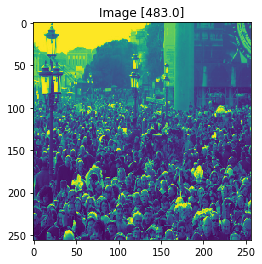

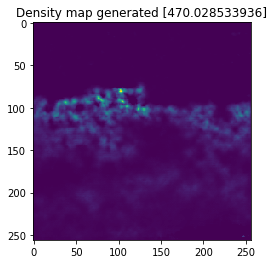

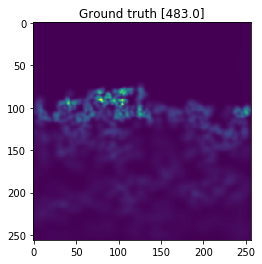

In [17]:
train(models, optimizers, loss_fn, 10)

Epoch 1 started
Discriminator loss after 0 batches: 5.96046518808e-08
Generator loss after 0 batches: 41.9875946045
Discriminator loss after 100 batches: 0.00016304528981
Generator loss after 100 batches: 19.1339149475
Discriminator loss after 200 batches: 0.000405893515563
Generator loss after 200 batches: 18.1098709106
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 0.0
Generator loss after 0 batches: 43.719997406
Discriminator loss after 100 batches: 0.0111311310902
Generator loss after 100 batches: 14.9415397644
Discriminator loss after 200 batches: 1.69873521827e-06
Generator loss after 200 batches: 23.9893913269
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 8.94069742685e-08
Generator loss after 0 batches: 41.9949417114
Discriminator loss after 100 batches: 5.73429570068e-05
Generator loss after 100 batches: 19.8755531311
Discriminator loss after 200 batches: 3.27

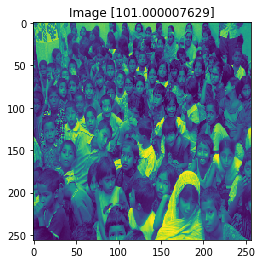

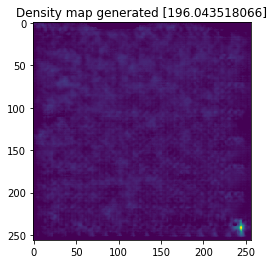

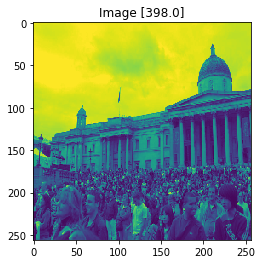

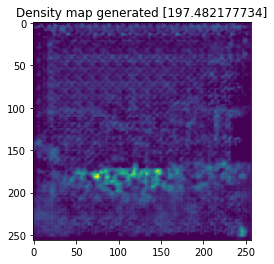

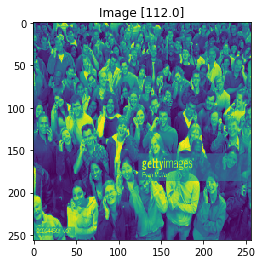

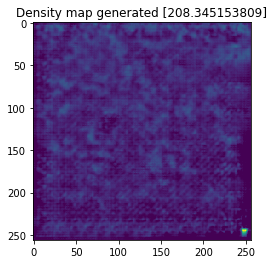

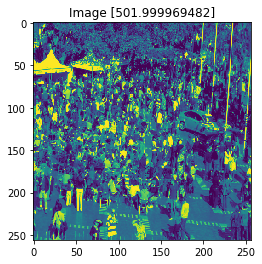

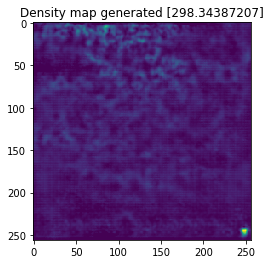

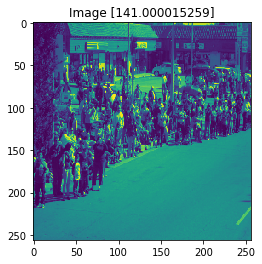

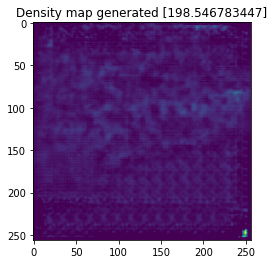

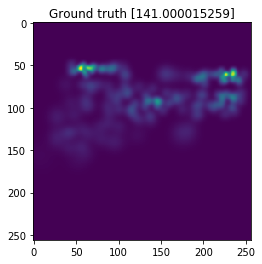

In [18]:
train(models, optimizers, loss_fn, 10, evalz = True)

Epoch 1 started
Discriminator loss after 0 batches: 5.96046518808e-08
Generator loss after 0 batches: 43.1669235229
Discriminator loss after 100 batches: 5.96046788814e-07
Generator loss after 100 batches: 24.6913757324
Discriminator loss after 200 batches: 0.00300264102407
Generator loss after 200 batches: 15.7904949188
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 0.00813870411366
Generator loss after 0 batches: 29.9128742218
Discriminator loss after 100 batches: 2.80142626252e-06
Generator loss after 100 batches: 23.6318397522
Discriminator loss after 200 batches: 0.000330795970513
Generator loss after 200 batches: 17.7597904205
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 0.00478295003995
Generator loss after 0 batches: 31.1819820404
Discriminator loss after 100 batches: 9.2387284667e-07
Generator loss after 100 batches: 23.7580013275
Discriminator loss after 200

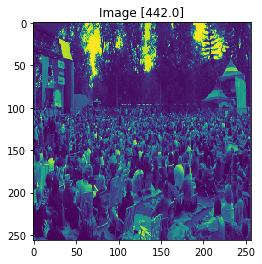

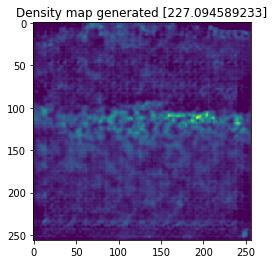

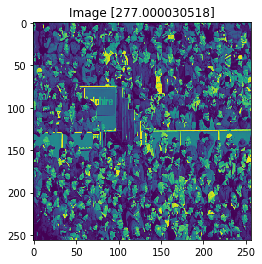

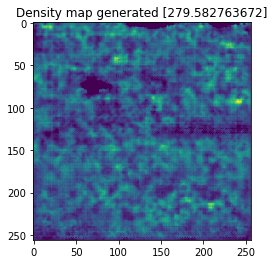

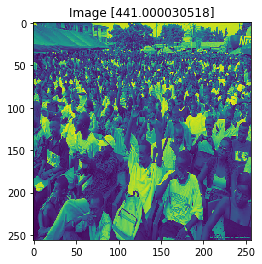

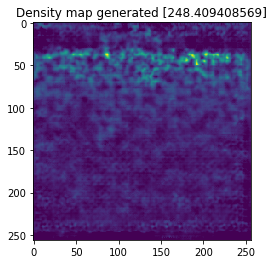

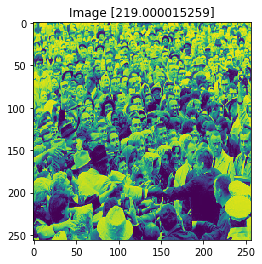

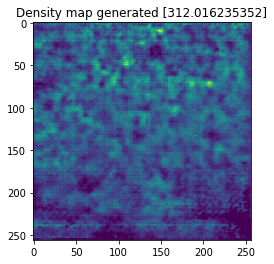

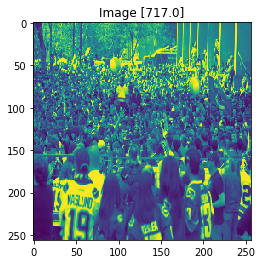

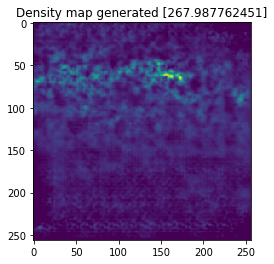

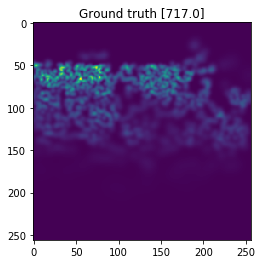

In [19]:
train(models, optimizers, loss_fn, 10, evalz = True)

Epoch 1 started
Discriminator loss after 0 batches: 0.000162687545526
Generator loss after 0 batches: 33.9414215088
Discriminator loss after 100 batches: 0.000136423841468
Generator loss after 100 batches: 19.4055843353
Discriminator loss after 200 batches: 0.00150716735516
Generator loss after 200 batches: 16.8726482391
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 0.000322445877828
Generator loss after 0 batches: 32.6822357178
Discriminator loss after 100 batches: 5.16500913363e-05
Generator loss after 100 batches: 19.7797756195
Discriminator loss after 200 batches: 3.26942172251e-05
Generator loss after 200 batches: 20.3072509766
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 1.03713155113e-05
Generator loss after 0 batches: 36.5440063477
Discriminator loss after 100 batches: 0.00074943411164
Generator loss after 100 batches: 17.2043056488
Discriminator loss after 2

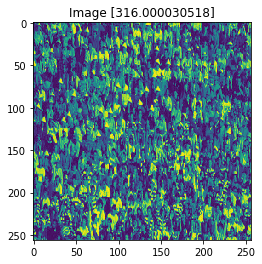

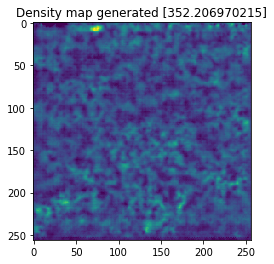

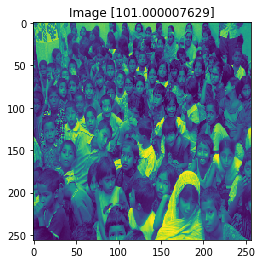

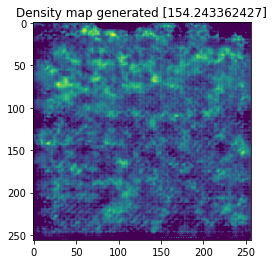

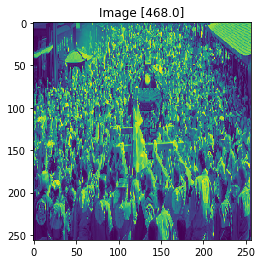

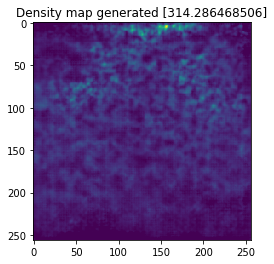

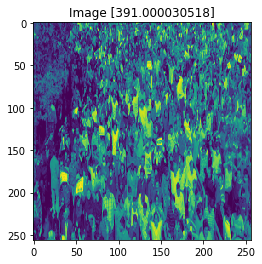

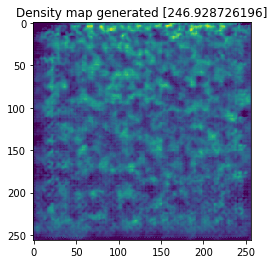

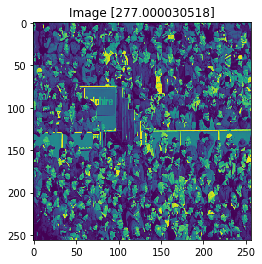

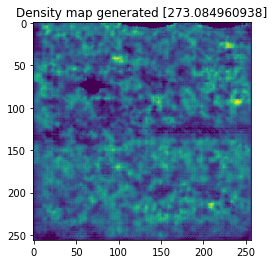

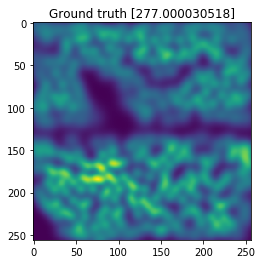

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

Epoch 1 started
Discriminator loss after 0 batches: 6.04990782449e-06
Generator loss after 0 batches: 37.2831001282
Discriminator loss after 100 batches: 0.000160213152412
Generator loss after 100 batches: 18.8264350891
Discriminator loss after 200 batches: 4.76837328733e-07
Generator loss after 200 batches: 24.8659076691
Epoch ended
Creating tensor from image...
Tensor of shape: torch.Size([1, 1, 256, 256]) created
Epoch 2 started
Discriminator loss after 0 batches: 0.000422566838097
Generator loss after 0 batches: 32.8227005005
Discriminator loss after 100 batches: 0.000275747501291
Generator loss after 100 batches: 18.0227279663
Discriminator loss after 200 batches: 1.89248330571e-05
Generator loss after 200 batches: 20.8335609436
Epoch ended
Epoch 3 started
Discriminator loss after 0 batches: 0.000795311119873
Generator loss after 0 batches: 32.1845779419
Discriminator loss after 100 batches: 0.000195720349438
Generator loss after 100 batches: 18.9600982666
Discriminator loss after

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)

In [ ]:
train(models, optimizers, loss_fn, 10, evalz = True)